In [1]:
## this workflow follows the tutorial published by Dr. Mort Canty
## https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-2

In [2]:
## import Earth Engine API

import ee

ee.Authenticate()

ee.Initialize()

In [2]:
## imports maptlotlib and numpy

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, gamma, f, chi2
import IPython.display as disp
%matplotlib inline

In [3]:
import os

In [4]:
## import folium

import folium

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [5]:
## define coordinates of AOI
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -59.448394775390625,
              47.755944512091666
            ],
            [
              -59.07485961914062,
              47.755944512091666
            ],
            [
              -59.07485961914062,
              47.938426929481054
            ],
            [
              -59.448394775390625,
              47.938426929481054
            ],
            [
              -59.448394775390625,
              47.755944512091666
            ]
          ]
        ]
      }
    }
  ]
}
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi = ee.Geometry.Polygon(coords)
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -59.360504150390625,
              47.88411800496604
            ],
            [
              -59.31243896484375,
              47.88411800496604
            ],
            [
              -59.31243896484375,
              47.9062166475376
            ],
            [
              -59.360504150390625,
              47.9062166475376
            ],
            [
              -59.360504150390625,
              47.88411800496604
            ]
          ]
        ]
      }
    }
  ]
}
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi_sub = ee.Geometry.Polygon(coords)

In [20]:
## filter through S1 imagery to collect 2 images from the designated period of time

im_coll = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')
                .filterBounds(aoi)
                .filterDate(ee.Date('2016-08-01'),ee.Date('2020-08-31'))
                .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
               .filter(ee.Filter.eq('relativeOrbitNumber_start', 47))
                .sort('system:time_start'))

In [21]:
## get info of the acquisition times

import time
acq_times = im_coll.aggregate_array('system:time_start').getInfo()
[time.strftime('%x', time.gmtime(acq_time/1000)) for acq_time in acq_times]

['09/27/16',
 '10/09/16',
 '10/21/16',
 '11/02/16',
 '11/14/16',
 '11/26/16',
 '12/08/16',
 '12/20/16',
 '01/01/17',
 '01/13/17',
 '01/25/17',
 '02/06/17',
 '02/18/17',
 '03/02/17',
 '03/14/17',
 '03/26/17',
 '04/07/17',
 '04/19/17',
 '05/01/17',
 '05/13/17',
 '05/25/17',
 '06/06/17',
 '06/18/17',
 '06/30/17',
 '07/12/17',
 '07/24/17',
 '08/05/17',
 '08/17/17',
 '08/29/17',
 '09/10/17',
 '09/22/17',
 '10/04/17',
 '10/16/17',
 '10/28/17',
 '11/09/17',
 '11/21/17',
 '12/03/17',
 '12/15/17',
 '12/27/17',
 '01/08/18',
 '01/20/18',
 '02/01/18',
 '02/13/18',
 '02/25/18',
 '03/09/18',
 '03/21/18',
 '04/02/18',
 '04/14/18',
 '04/26/18',
 '05/08/18',
 '05/20/18',
 '06/13/18',
 '06/25/18',
 '07/19/18',
 '07/31/18',
 '08/12/18',
 '08/24/18',
 '09/05/18',
 '09/17/18',
 '09/29/18',
 '10/11/18',
 '10/23/18',
 '11/04/18',
 '11/16/18',
 '11/28/18',
 '12/10/18',
 '12/22/18',
 '01/03/19',
 '01/15/19',
 '01/27/19',
 '02/08/19',
 '02/20/19',
 '03/04/19',
 '03/16/19',
 '03/28/19',
 '04/09/19',
 '04/21/19',

In [22]:
## selects the first two images and extracts the VV bands

im_list = im_coll.toList(im_coll.size())
im1 = ee.Image(im_list.get(0)).select('VV').clip(aoi_sub)
im2 = ee.Image(im_list.get(1)).select('VV').clip(aoi_sub)

In [23]:
ratio = im1.divide(im2)
url = ratio.getThumbURL({'min': 0, 'max': 10})
disp.Image(url=url, width=800)

In [24]:
## use reducers to calculate the histogram, mean and variance of the ratio image

hist = ratio.reduceRegion(ee.Reducer.fixedHistogram(0, 5, 500), aoi_sub).get('VV').getInfo()
mean = ratio.reduceRegion(ee.Reducer.mean(), aoi_sub).get('VV').getInfo()
variance = ratio.reduceRegion(ee.Reducer.variance(), aoi).get('VV').getInfo()

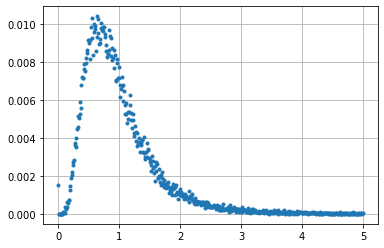

In [25]:
## plot the normalized histogram using numpy and matplotlib

a = np.array(hist)
x = a[:, 0]
y = a[:, 1] / np.sum(a[:, 1])
plt.grid()
plt.plot(x, y, '.')
plt.show()

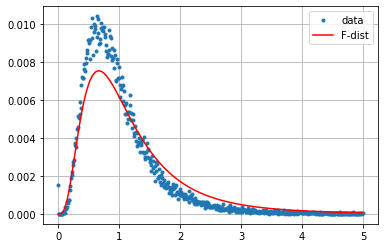

In [26]:
## bin widths are 0.001, divide by 100

m = 5
plt.grid()
plt.plot(x, y, '.', label='data')
plt.plot(x, f.pdf(x, 2*m, 2*m) / 100, '-r', label='F-dist')
plt.legend()
plt.show()

In [27]:
## verify the mean and variance

print(mean, m/(m-1))
print(variance, m*(2*m-1)/(m-1)**2/(m-2))

10.438808669081965 1.25
1044446.4232178305 0.9375


In [28]:
## check the f distribution of the two uncorrelated multilook images for change detection
## likelihood ratio test statistic

watermask = ee.Image('UMD/hansen/global_forest_change_2015').select('datamask').eq(1)  

im1 = ee.Image(im_list.get(0)).select('VV').clip(aoi).updateMask(watermask)
im2 = ee.Image(im_list.get(1)).select('VV').clip(aoi).updateMask(watermask)
ratio = im1.divide(im2)

location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(location=location, zoom_start=12)
mp.add_ee_layer(ratio,
                {'min': 0, 'max': 20, 'palette': ['black', 'white']}, 'Ratio')
mp.add_child(folium.LayerControl())

display(mp)

In [29]:
## distinguish the direction of change and mask out the no-change pixels

# Decision threshold alpha/2:
dt = f.ppf(0.0005, 2*m, 2*m)

# LRT statistics.
q1 = im1.divide(im2)
q2 = im2.divide(im1)

# Change map with 0 = no change, 1 = decrease, 2 = increase in intensity.
c_map = im1.multiply(0).where(q2.lt(dt), 1)
c_map = c_map.where(q1.lt(dt), 2)

# Mask no-change pixels.
c_map = c_map.updateMask(c_map.gt(0))

# Display map with red for increase and blue for decrease in intensity.
location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(
    location=location, tiles='Stamen Toner',
    zoom_start=13)
folium.TileLayer('OpenStreetMap').add_to(mp)
mp.add_ee_layer(ratio,
                {'min': 0, 'max': 20, 'palette': ['black', 'white']}, 'Ratio')
mp.add_ee_layer(c_map,
                {'min': 0, 'max': 2, 'palette': ['black', 'blue', 'red']},
                'Change Map')
mp.add_child(folium.LayerControl())

display(mp)

In [16]:
## save html file
mp.save('sentinel1_map.html')

In [17]:
## bivariate change detection
def det(im):
  return im.expression('b(0) * b(1)')

# Number of looks.
m = 5

im1 = ee.Image(im_list.get(0)).select('VV', 'VH').clip(aoi).updateMask(watermask)
im2 = ee.Image(im_list.get(1)).select('VV', 'VH').clip(aoi).updateMask(watermask)

m2logQ = det(im1).log().add(det(im2).log()).subtract(
    det(im1.add(im2)).log().multiply(2)).add(4*np.log(2)).multiply(-2*m)

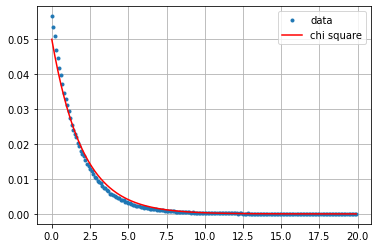

In [18]:
## plot it's histogram with the chi square distribution with two degrees of freedom

hist = m2logQ.reduceRegion(
    ee.Reducer.fixedHistogram(0, 20, 200), aoi).get('VV').getInfo()
a = np.array(hist)
x = a[:, 0]
y = a[:, 1] / np.sum(a[:, 1])
plt.plot(x, y, '.', label='data')
plt.plot(x, chi2.pdf(x, 2)/10, '-r', label='chi square')
plt.legend()
plt.grid()
plt.show()